### svm

利用SMO方法实现svm

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

---
#### 一些基本的辅助函数

In [2]:
def loadDataset(filename):
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        #print(line)
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

X_train,y_train=loadDataset('testSet.txt')

In [3]:
# 返回在0~m样本范围内,和i不同的随机的一个值
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    
    return j


In [4]:
# 把alpha clip到H和L范围内
def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    elif aj<L:
        aj=L
    return aj


In [12]:
# dataSe: 是数据集
# labels: 是标签,+1和-1
# C是 alpha的最大值,约束条件
# toler 误差容忍
# maxIter: alpha不再变化的最大迭代次数,尝试这么多次的迭代alpha都不在变化后,认为找到最优的alpha.
def smo(dataSet,labels,C,toler,maxIter):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    b=0
    m,n=X.shape
    #alphas=np.zeros([m,1],np.float32)
    alphas = np.mat(np.zeros((m,1),np.float32))
    #print(alphas)
    iterI=0
    
    #debug
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        #print("X.shape:%s,y.shape:%s"%(X.shape,y.shape))
        #print("X:%s,y:%s"%(X,y))
        print(maxIter)
        
    while(iterI<maxIter):# end
        # update
        alphaPairsChanged=0
        for i in range(m):# end
            fXi=float(np.multiply(alphas,y).T*(X*X[i,:].T))+b
            print("fXi:%s",fXi)
            print(alphas.shape)
            print(y.shape)
            print((np.multiply(alphas,y).T).shape)
            print(X.shape)
            print(X[i,:].shape)
            
            Ei=fXi-float(y[i])
            
            if DEBUG_SVM == True:
                #print("alpha:%s",alphas)
                print("[i:%d] fXi:%s,y[%d]:%s,Ei:%s" %(i,fXi,i,y[i],Ei))

            
            # KKT conditions
            # 第一: 偏差大于 toler. y[i]表符号.
            # 第二: alphas[i]满足0~C,而且不能取边界; 这个边界问题我还没搞懂
            if ((y[i]*Ei<-toler) and alphas[i]<C ) or ((y[i]*Ei>toler)and alphas[i]>0): #kkt条件,参考<<支持向量机通俗导论>>及<<支持向量机导论>>
                j=selectJrand(i,m)
                fXj=float(np.multiply(alphas,y).T*(X*X[j,:].T))+b
                
                Ej=fXj-y[j]

                if DEBUG_SVM == True:
                    print("[j:%d] fXj:%s,y[%d]:%s,Ej:%s" %(j,fXj,j,y[j],Ej))
                
                alpha_i_old=alphas[i].copy()
                alpha_j_old=alphas[j].copy()
                if y[i]!=y[j]:
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[i]+alphas[j]-C)
                    H=min(C,alphas[j]+alphas[i]) #### 2018-08-15debug issue:   这部分的逻辑出现问题了.注意同号时候要相加.
                if L==H: #### 2018-08-15debug issue:   这部分丢掉了L和H相等的时候,是alphas[i]和alphas[j]同为0时,此时后面没必要再去计算,更新量都为0.
                    print("L==H")
                    continue
                eta=2.0*X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                if DEBUG_SVM == True:
                    print("eta:%s"%eta)
                    print("i:%d,X[i,:]:%s" %(i,X[i,:]))
                    print("j:%d,X[j,:]:%s" %(j,X[j,:]))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,j,X[i,:]*X[j,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,i,X[i,:]*X[i,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(j,j,X[j,:]*X[j,:].T ))
                    
                if eta>=0:
                    print("eta >=0")
                    continue
                alphas[j]-=y[j]*(Ei-Ej)/eta # 更新alpha[j]
                alphas[j]=clipAlpha(alphas[j],H,L)
                if DEBUG_SVM == True:
                    print("Ei-Ej:%s"%(Ei-Ej))
                    print("L:%s,H:%s"%(L,H))
                    print("(Ei-Ej)/eta:%s" %((Ei-Ej)/eta))
                    print("alphas[%d]:%d"%(j,alphas[j]))

                if(np.abs(alphas[j]-alpha_j_old)<0.00001):
                    print("j not move")
                    continue
                alphas[i]+=y[j]*y[i]*(alpha_j_old-alphas[j])
                
                b1=b-Ei-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                b2=b-Ej-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                if (0<alphas[i]) and (C>alphas[i]):
                    b=b1
                elif (0<alphas[j]) and (C>alphas[j]):
                    b=b2
                else:
                    b=(b1+b2)/2.0
                    
                alphaPairsChanged+=1
                print("iter: %d i:%d, pairs changed %d" % (iterI,i,alphaPairsChanged))
        #if DEBUG_SVM==True:
        #    break
            
        if alphaPairsChanged==0:
            iterI+=1
        else:
            iterI=0
        print("iteration num: %d"%iterI)
    
    return b,alphas
                
                
            
        # break
    
b,alphas=smo(X_train,y_train,0.6,0.001,40)    

fXi:%s 0.0
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:0, pairs changed 1
fXi:%s [[-4.34278644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.45611991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:%s [[-4.4872898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.44785033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:4, pairs changed 2
fXi:%s [[ 0.55817336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:%s [[ 0.96286274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.48915318]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.05501286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.22208892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.16333455]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.49946443]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86581031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.66433371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move

(100, 2)
(1, 2)
j not move
fXi:%s [[ 1.99895188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.5404165]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:84, pairs changed 9
fXi:%s [[-1.97993927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04421878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99564448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.57475426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.22571169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.9316346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.47305548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.1767142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28760889]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.56374854]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86257459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.61126316]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:9

(1, 2)
L==H
fXi:%s [[-2.26761671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36200914]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.85745581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10210823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.74795606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.9587762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.2070183]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.67421859]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.79555977]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.0155869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.1319036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.30013126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.05914534]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.07878168]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.71845737]]
(100, 1)
(100, 1)
(1, 1

fXi:%s [[ 1.82289379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.0515957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.56038934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.68616314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36632343]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.62525699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.58457898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.83932363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.04507774]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-3.64787061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.07589163]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.46047584]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.00143754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.64853904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 1.09798015]]
(100, 1)
(

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.56140272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:%s [[-2.11799065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.47118242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:%s [[-0.85645039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.11106322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.29071762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.02988351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.05660924]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.618285]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.38458492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.81993395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.84175869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.14603143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.06436398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0449913]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.17438231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07289377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 1 i:87, pairs changed 4
fXi:%s [[ 2.96709454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13777318]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.68966565]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83063528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.65940284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.2677753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.18127219]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.58115562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.1954776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.12137322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.1647899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.8888

fXi:%s [[-1.49057355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96879496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.0762013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.30555553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77129073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91481191]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.73044415]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.97668537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83478321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81362117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.59807195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.53978717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.72785007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.07235033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82946009]]
(100, 1)
(100, 1)
(1, 100)
(100,

fXi:%s [[-1.60659818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.05003416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00444398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.98255977]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.35431909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02597371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.75394857]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96367002]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.65648325]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.22343225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59484166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.5566398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.35816944]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.20735745]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:54, pairs changed 1
fXi:%s [[ 0.79643431]]
(1

(100, 2)
(1, 2)
fXi:%s [[ 1.50570556]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3165625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.71765837]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.74307008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09543518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99183543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.72624822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47332765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66421176]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48889466]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30934873]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.38850314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.94327276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52457207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.39130924]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.45550921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37598715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37301759]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09960007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.13820769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.73622661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.18104122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.09111355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.74200165]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.87152149]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97837552]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89583945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.89637221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.19618865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.49375162]]
(100, 1)
(100, 1)
(

fXi:%s [[-1.67585834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.31553141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.1772156]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23734989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00667809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:%s [[-1.26526683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.79283492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.55400821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.80854386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.2564068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.08188289]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41503144]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.72217491]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.13643321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.87871602]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

fXi:%s [[-2.00167468]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4422624]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81025956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41267456]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91378774]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.83587082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.23946269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52494884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86483223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.76164844]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.28521627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.86237756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.25610143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.08266094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.90023533]]
(100, 1)
(100, 1)
(1, 100)
(100,

fXi:%s [[-1.98728319]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.07517014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.08923644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.46416206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.86775692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.68750185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.76840631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.61912735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.03308245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.35613906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.06541341]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77091747]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.64662169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.04420689]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97191423]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30794679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66505816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14099957]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.0630515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.95953693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.86322407]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.76403866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.14089904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.73847902]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.76701599]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.91927102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18606179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52285438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.79035085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

fXi:%s [[-2.91413213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.17832578]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.50963221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.88001203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.31033162]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59895403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.87601257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03418051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.26505497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45586477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.17254544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28899039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37615715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.32818505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33352125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07835554]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18761253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10320753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.78856599]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40972158]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.39940905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.64953514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.35863469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.51802697]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47031303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.87828822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.51027055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36963681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.45161519]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.21577103]]
(100, 1)
(100, 1)
(1, 100)
(

fXi:%s [[-2.20232749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.18712557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52774538]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40655856]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.69905258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97251038]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66703476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.03123484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.65685601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36287323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.72533]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28829596]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.75441023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.23422309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.01400911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fX

(100, 2)
(1, 2)
fXi:%s [[ 2.08624917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.03035994]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99168031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12677315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23824682]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.1521082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82540765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46387095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.44869266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68394424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38958373]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.57440927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.50753449]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.92264006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.54783446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.642096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.72496549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44981968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.39967383]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.13329711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.25340044]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.81236672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25672561]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.21671287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99974431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14693219]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.26868008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.17414317]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.9688536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.49357401]]
(100, 1)
(100

fXi:%s [[-3.78476046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.0048547]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.35161486]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32845704]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.0862962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.93606046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.29884794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00789252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61444971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12070077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28043092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.39453117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.62910775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47426582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.88080291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32507841]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.28537927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93970692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0875615]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20987812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11487267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.03495405]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4345606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.71999093]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.88869428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.62208722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.55667169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.43441902]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86341872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.46782692]]
(100, 1)
(100, 1)
(1,

fXi:%s [[-1.85988119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.79707735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93620549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11119917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46271862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.44916294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33679782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.66742565]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.90096856]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98760965]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32536929]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.93151703]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6640448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.05551155]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.19796052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3

(1, 2)
fXi:%s [[ 2.40073314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60552097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.26369144]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27262291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52322714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.50242202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38719194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20930403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.62190271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.66065762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38334223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42260912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.10552065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.21218059]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.79064939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.55933827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41997979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23938248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.68063876]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.68237969]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42321389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46307885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14116085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.26467621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83672471]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.19659453]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.20079153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02367096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.15689223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.26650839]]
(100, 1)
(

(1, 2)
fXi:%s [[ 2.21900867]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02854754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.60533571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.55227357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.83277848]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.17269112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42469821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.1668079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.04207968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.40484904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.82227906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.73303782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91862502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0816264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47150803]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.99612102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.05620061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.65241205]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.04842483]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99592299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93355663]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05925598]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16268301]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08322394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82991639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.39366632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.40714569]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.69018723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36374956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.49544927]]
(100, 1)
(100, 1)
(

fXi:%s [[-1.49605798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.93143096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.74452767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.79152873]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.68759555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.0408488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.37198308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.12793457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.8505303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.73930767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.11278429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00765589]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44108393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.095019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25674249]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

fXi:%s [[ 2.34604447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.89717068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.11976594]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.13279732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.7441939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04181969]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.94651641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.22024674]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99675226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.50548955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.03243451]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.82998697]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.69772906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.60502818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.95981397]]
(100, 1)
(100, 1)
(1, 100)
(100,

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.19458999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4187809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43433079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.42444173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.42679288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27306111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.50038183]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73601263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.3222997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.2935813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02117101]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.11495998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68752717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.12634477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.07305134]]
(100, 1)
(100, 1)
(1, 100)
(100

(1, 2)
fXi:%s [[-1.10197821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.49535915]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.00056982]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.8114419]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81457946]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.75640016]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.04306011]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.38201882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.20795572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.94818743]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.81777335]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.18570535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02810484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50793375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12799212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.40854891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38110637]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.11098452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.19321494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77045457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.2143095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15145706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.88678424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02563677]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14035507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05148695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92891113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3621246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.57085033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7874117]]
(100, 1)
(100, 1)
(1, 100)
(100

fXi:%s [[-1.66115393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14636992]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92743628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.72049541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09457179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32141556]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37531292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47054097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.61983964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25610642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.98644284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.78877735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-4.29784569]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23204353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67677241]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 

fXi:%s [[-2.31639961]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47854841]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.61308629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.50797121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.76216776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.83128343]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.51707285]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61262616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.39066277]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.96663289]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.79343189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23181595]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81650937]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.71610611]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.86512439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47073324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.59437355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46190028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.85301621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99291892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98219057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.29914058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.89758176]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.65653616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.04363649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33742456]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.07844656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.51783117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.97089851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.95413357]]

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.59618327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47141388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9108423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.51601025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3605548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52701701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27578458]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:%s [[-1.46214524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04303899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7417628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05459423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.40845095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.22174895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.58100137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9603069

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42061115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7789643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33568362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83001128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.28564691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.04255213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.97377386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.95836121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.85533263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.16216326]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.86752984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.81254047]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.97069495]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20907593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

fXi:%s [[-1.26806508]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.79860939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60145203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93104025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41652744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.13005423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61886308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.82769553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.14327577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.10067265]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.21817881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.75324732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.26121884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44960382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.98750164]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 

fXi:%s [[-3.71353418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.87201851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91657713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25168153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.86457406]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60611467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96943918]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23826389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.02431729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46818967]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.92253273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.8701582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.1141945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 1.01199735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 1 i:55, pairs changed 1
fXi:%s [[-2.03278463]]
(10

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.98450054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11613182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56700213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47023495]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25579127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.73378935]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.69197956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92717381]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.24712919]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.87059081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6431791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.9455737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.22510819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.10942556]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48719705]]
(100, 1)
(10

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.98758712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86472299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42811833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.94003102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.23098907]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.18782038]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.01222604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.65401621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.60201909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.86318794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.20219817]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4338448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.17766433]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.94473746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.

(100, 2)
(1, 2)
fXi:%s [[-2.36420744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20672356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.70763216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.6565673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50079655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47137715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.19231817]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.31280331]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.87493811]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30005896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.26987182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.94654945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09047111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20938408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11725617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 2)
(1, 2)
fXi:%s [[-1.71145991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.72174315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.91963712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.27096707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43140075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.19722681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.10400408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42541451]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95230283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.79442845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02934337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20799497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45134268]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.55220418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43855567]]
(100, 1)
(100, 1)
(1, 100)

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.90517295]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30294313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.29573304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99014216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13263772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25023292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.1593436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.07845693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.48728905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.73601648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92960032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.62143535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.60393189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.48049593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91728831]]
(100, 1)
(100, 1)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.71947098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.78205325]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.80475797]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96957332]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.49363362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30036543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.17829562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.49116556]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73831851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98366309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.33720324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.95622389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67384212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.043531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05675256]]
(100, 1)
(100, 1)
(1,

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38495723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.6940968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.89061133]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6073863]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.50204819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.39941512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.82469897]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.43668134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.30128312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4261597]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.1724436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:%s [[-1.37833474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93668699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66871296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97328475]]
(100, 

fXi:%s [[-3.87426246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97191919]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.87941236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.20045856]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.807847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56702305]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92846086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36782774]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99939306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42411977]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.03454667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.9954849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.03375022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.94391172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.17388157]]
(100, 1)
(100, 1)
(1, 1

(1, 2)
fXi:%s [[-1.52605086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.39604282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52943558]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.26874232]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:%s [[-1.46443304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02620275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61016608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07432775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32405606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.10834627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50449024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97792089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.32853167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.23902737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35613085]]
(100, 1)
(100, 1)
(1, 100)
(1

fXi:%s [[ 2.98631482]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41481278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.03744618]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.99852328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.03014407]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.93560103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.18150251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.9649526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.86447301]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.02616708]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23152348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.60065574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.03621519]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38109239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.79063681]]
(100, 1)
(100, 1)
(1,

(1, 2)
fXi:%s [[ 2.32405606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.10834627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50449024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97792089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.32853167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.23902737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35613085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86615361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.31657895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48055006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0908896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48461644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.01407358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.98282733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.30908445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.65594909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.810342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03277299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3987257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09499769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18206626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82398083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73512147]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9139488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50516026]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.69362951]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.38119585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.2637965]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61078958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.60493366]]
(100, 1)
(100, 1)
(1, 100)
(100, 

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.34447497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4280908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09221571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48450902]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99455216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.90803453]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.32652515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.81498519]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12408477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00442643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.34320079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.0575238]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.39730244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.10889015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.92467508]]

(100, 2)
(1, 2)
fXi:%s [[-1.88988248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08605822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45736376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.64532746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.30102865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.51240575]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.55946744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.59338145]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40556766]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27296052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.62474169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73107767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47390363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37081509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.13786157]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.63267099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9555311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.83830398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42227122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.91028408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.24359298]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.19271911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.01214537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.62046938]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.5570791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.84142721]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.17889134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42116733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.1601134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.97193102]]


(1, 2)
fXi:%s [[ 3.54371605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.21416042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05605601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.63113623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.52519516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45629629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44813812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.16742705]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.24544403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.8273979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25580749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.19808775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81886108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95410699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06571939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.96054274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.61053894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.52538663]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.85242338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.1868376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.34774737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.07750054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96517613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.33244698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.82880683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6639984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91703535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08036071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38552473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41162103]]
(100, 1)
(

fXi:%s [[ 2.16742705]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.24544403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.8273979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25580749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.19808775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81886108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95410699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06571939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97945418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99186576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.29071492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.61597114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.85058245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.55809591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40142341]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.90769046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.26421711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89067413]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61354887]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9644952]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13374956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.29015617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46062904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3519492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.63893604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.93041397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.79783221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.15731154]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.77637656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48487941]]
(100, 1)
(100, 1)
(1,

fXi:%s [[-2.19487973]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11314066]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.85973019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.42671695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.45294741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.71832481]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.39639065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.53146688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47912524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89419274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.5254699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36785424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4725423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.24280618]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:%s [[-1.47904135]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54814609]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4504516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.71952476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04320796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70491669]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.06744189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.68536959]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38835092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77570365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30498199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.76759564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.26452128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00164431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.93760048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.99794773]]
(100, 1)
(100, 1)


(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.49410044]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9090717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.54227197]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.38000008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.48569111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25930352]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 5
fXi:%s [[-1.49779179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05030427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.49427727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03510087]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.15156778]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.99890866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30607188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.94912333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36157

(100, 2)
(1, 2)
fXi:%s [[ 2.38835092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77570365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30498199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.76759564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.26452128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00164431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.93760048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.99794773]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.84076855]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.17903388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.92769858]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.77930361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.94522632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.21888729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.53378044]]
(100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03608227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59677896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09149553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.31819691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09574786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50112005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99416103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.33951128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.26074219]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.371202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.88514805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.34202921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46482629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11148467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47720783]]
(100, 1)
(10

(100, 2)
(1, 2)
fXi:%s [[ 1.09331791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.92709353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.26648943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.07657314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.90130286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.07677393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30863629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.64165057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.05853993]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43849753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83402555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97534074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13098305]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45785297]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66772967]]
(100, 1)
(100, 

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.45507067]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.39850438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.49087454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.01176655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47766351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36834333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.24104037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38876096]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91841111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.09621633]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.21662539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.99364808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28457795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16677549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.24712785]]
(100, 1)

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.6012687]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.06248162]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38378414]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82313494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.92128706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09701282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47883186]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67843818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.31558012]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40816167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59318892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.61354292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41641828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25799078]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.69180259]]
(100, 1)
(100, 1)
(1, 100)
(1

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56222513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.09858309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.93511755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.38115215]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.7872989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07626643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96237207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42307032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99239516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.39942679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.19962762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.00471631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.72564386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.72367572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.93215873]]
(100, 1

(100, 2)
(1, 2)
fXi:%s [[ 2.70162563]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.36518438]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.31750066]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61763608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.62429794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30010991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14999847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.69088104]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.60816754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.51069772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46529573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.1997493]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.30585269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.87099007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.3185131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32372178]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.97130679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.34926607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.105499]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.91967549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.67748587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.60208381]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.91086975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.24670383]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.31541666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.04922467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.90821626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.28856962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.88355273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59797874]]
(100, 1)

(1, 2)
fXi:%s [[ 3.55629117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.60420717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38050172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.37233709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09139909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.17028724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7519033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.17985086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.12289266]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89811049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03346568]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14516826]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05883335]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91650411]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.37034564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.01726142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.35419627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.2017627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.9366142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.83530333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.19117467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00430331]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53512717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08570708]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25364434]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.23037513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.58557952]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46786072]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.78113049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03165214]]
(100, 1)
(100, 1)
(

fXi:%s [[ 2.1085812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.06454625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10481943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.24913632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3684465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27590056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82678108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.59343644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.49469368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68183304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.40741653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.71233708]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.60534105]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03054195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.64068182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61559732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.94602725]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.09401533]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4477399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43397761]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.2685137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.65245799]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.77200346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.87283954]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.21417628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.83757925]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.57719234]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91254659]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.19108764]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00514567]]
(100, 1)
(100, 1)
(1, 100)
(10

fXi:%s [[-2.29656973]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.64763074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.82631731]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.58963131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41819252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.32817244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.74089148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35597283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.24593638]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3318476]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07062734]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 4
fXi:%s [[-1.29053001]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.82693206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60637945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89851306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(100, 2)
(1, 2)
fXi:%s [[-1.95617695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6902248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.05230422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.67727658]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38608653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.74761095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27792099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.78012113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25654583]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00168193]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.91995421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.96795821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.85027195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.12135203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.86927273]]
(100,

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35654679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.44026809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.20273593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:%s [[-1.44339747]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.98242673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45979756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0023302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.15950891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.97752757]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.32299413]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91354018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.31192262]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.09883779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3236526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.796901

(1, 2)
fXi:%s [[ 2.83926501]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.24433762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.21624678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.16400288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.83086368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 0.77578609]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.30738701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.74135997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.01889489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.17339287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36190697]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.75205444]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.86229842]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.52280222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60709271]]
(100, 1)
(100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.28083435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02511209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47816609]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16629684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47555456]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.48275382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.52527143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06667615]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.56056016]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38869561]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30456575]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43661678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96891882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.09307604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.26941881]]

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.99068492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.90087837]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.06167412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23957908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.62951505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.09380843]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.39929334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.85865587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9290533]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12035347]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52808227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.72482678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.34559539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.50563374]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.63750915]]
(100, 1)
(100, 1)
(1, 100)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.88594306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36197243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52803455]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11851786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.55748356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.08912155]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.94948404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.3865972]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.8734684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.15976876]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04000962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41412068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.06373889]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.43858574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.17943843]]

(100, 2)
(1, 2)
fXi:%s [[ 2.86093584]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91393495]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08824418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.5113507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.71309089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.34220359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38840667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.62752955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.65094809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.40905338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.24715269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.73458832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.69000648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50835693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48651841]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

j not move
fXi:%s [[ 2.39998048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.83427341]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10767614]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99485229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45235342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00538243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.44341834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.23083642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.0296057]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.74984692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.77786179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.94850148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.30277554]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43746634]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.21023277]]
(100, 1)
(100, 1)
(1, 100)
(100,

fXi:%s [[-1.92418259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70367607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05350431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4992303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.20731684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70846918]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.94617058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.23414287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.2763051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.30732875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.86423587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38925898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.54727891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10820889]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.64364892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.

j not move
fXi:%s [[ 1.05521128]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.10286727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.04984942]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.82782563]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.98665675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.15817402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.55513086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.16834654]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32159692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.93138647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.85073259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04646222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60681737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.80177258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.42283979]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 2)
(1, 2)
fXi:%s [[-3.21356827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.28053286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81386273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.29856931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59332749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0482819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.63551716]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.16330092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.85891642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.46861142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.79706229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0856894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96460748]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4914603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.9906829]]
(100, 1)
(100, 1)
(1, 100)
(10

(1, 2)
fXi:%s [[ 2.16834654]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32159692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.93138647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.85073259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04646222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60681737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.80177258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.42283979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.45503531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.71412709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.7680676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.37313099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23140968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81127199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.67459489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(1, 2)
fXi:%s [[ 3.16330092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.85891642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.46861142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.79706229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0856894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96460748]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4914603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.9906829]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.3536862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25426597]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.06336998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73396095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.76048062]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.9210621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.27433444]]
(100, 1)
(100, 1)


fXi:%s [[ 1.42283979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.45503531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.71412709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.7680676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.37313099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23140968]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81127199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.67459489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61954046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53158921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.28205025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.42521248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96921596]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43590461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.39881635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.41958718]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.18038671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.99019258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.80233328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.82583641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99014648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.3428626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41500604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.18697552]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00131549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.3715193]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00127673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66512064]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13676365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.2898749]]
(100, 1)
(100, 1)
(1

fXi:%s [[ 2.57218073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.27945616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.43501639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98474395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38441076]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.38830114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99070202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13783043]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25933956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16528355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15638548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.49764626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.83615709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00517467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70310949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.12613941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45443474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00065642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.80049261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10206525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27391461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52443655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.63045279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.48804788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.91249122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00182103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.03134514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.33611857]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.92953358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70357412]]
(100, 1)
(100, 1)
(1, 100)
(

fXi:%s [[-2.16528355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15638548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.49764626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.83615709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00517467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70310949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.61840943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47162094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91526891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.51194492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36700083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54144307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27936891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 7
fXi:%s [[-1.45260626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03601311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(100, 2)
(1, 2)
fXi:%s [[-3.91249122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00182103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.03134514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.33611857]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.92953358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70357412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.08996396]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36990363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.13724163]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56075621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.98718532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.98260032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.15024995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.0335409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.1903655]]
(100, 1)
(100, 1)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36700083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54144307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27936891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 14
fXi:%s [[-1.45260626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03601311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77449034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06794577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45966697]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25281776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6404261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97037686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3107323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.26305027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.32926208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.84785

(1, 2)
fXi:%s [[ 2.56075621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.98718532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.98260032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.15024995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.0335409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.1903655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.12404938]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.87902397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.04893502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23961688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.60907012]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.17291056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38793159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.95387819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91405242]]
(100, 1)
(100, 1)
(1, 100)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6404261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97037686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3107323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.26305027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.32926208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.84785106]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.29849159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.64598928]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07667657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.62976693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.18199765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.96645916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.44235366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.86338836]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13233339]]
(

(100, 2)
(1, 2)
fXi:%s [[-2.23961688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.60907012]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.17291056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.38793159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.95387819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.91405242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.0917442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59746212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.80313903]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.40553796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.39768195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7159115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.75925589]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41880209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25373189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.62976693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.18199765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.96645916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.44235366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.86338836]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13233339]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.01585299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.48711466]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.01886513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.44120989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25856813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.05781036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.77191907]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.8238174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.9577472]]
(100, 1)
(

(1, 2)
fXi:%s [[ 1.40553796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.39768195]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7159115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.75925589]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.41880209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25373189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.84455431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.68572637]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59439911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.57218073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.27945616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.43501639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98474395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38441076]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.38830114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.44120989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25856813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.05781036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.77191907]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.8238174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.9577472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.3159868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.47526917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.25738388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.12613941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45443474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.00065642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.80049261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.10206525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.27391461]]
(100, 1)
(1

fXi:%s [[ 2.57218073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.27945616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.43501639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.98474395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.38441076]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.38830114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.99070202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13783043]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.25933956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16528355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15638548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.49764626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.83615709]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00517467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.70310949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.08610906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41440031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05665198]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.7579467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.16135187]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33254947]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.49020326]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.69115975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54484084]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.98023782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05236806]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99400125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.29517526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.88738007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66608122]]
(100, 1)
(100, 1)
(1

fXi:%s [[-2.22327678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.11716772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.55646082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.80425966]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.96543577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66695349]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.67859907]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.52550481]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.97065971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.56495575]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.4220986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.59983802]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33506252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 6
fXi:%s [[-1.50435058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08908056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.98023782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.05236806]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.99400125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.29517526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.88738007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.66608122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.0512775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.42967308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.1037715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.52183557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.04322386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.04154819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.10144097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.98897428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.24546882]]
(100, 1)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.4220986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.59983802]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.33506252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 13
fXi:%s [[-1.50435058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.08908056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.73341302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12547623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.4221805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.21068497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60496137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02706534]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36233446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.32680799]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3833715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.905831

(100, 2)
(1, 2)
fXi:%s [[ 2.52183557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.04322386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.04154819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.10144097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.98897428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-2.24546882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.07672247]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.94070533]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.11051776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.29548788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.66916005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.13181254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.44584572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.91516236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96984541]]
(100, 1)
(100, 

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60496137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.02706534]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36233446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.32680799]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.3833715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.90583184]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.36166297]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60313462]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13628733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.59184985]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.1447537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.01369274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[ 2.40525736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.92369133]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.19065563]]
(

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28711674]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.66210284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14023559]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43815551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.9234925]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.96191485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14286248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56895809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77449592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.37113915]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46325739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.6867134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.73738825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.47175939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30862405]]
(100, 1)
(100, 1)
(1, 100)
(10

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60393037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15625319]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99947329]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41788488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.91106271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.17843286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06081501]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.46036982]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.06124646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.47900487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.22963515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02895552]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81712553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.87686586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99883413]]
(100, 1)
(100, 1)
(1, 100)
(

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.45708689]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68966312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.73968756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46651378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30325396]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.82060999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73355485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.57059912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.54073308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.25142287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.41161653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.95832931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36252996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.36698459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03424767]]
(100, 1)
(100, 1)
(

fXi:%s [[ 2.22963529]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02895566]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81712548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.87686585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-0.99883406]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:%s [[-1.35838134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44943588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.23461334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.09676116]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42603074]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04384548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.76823504]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.14949475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3202244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50366576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)


(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.95832931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36252996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.36698459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03424767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18317445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.3062189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.21089623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.12804664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54386935]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81658784]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.97636148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67951435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.66628994]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.51276583]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.9577761]]
(100, 1)
(100, 1)
(1, 100)
(10

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.15170437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32230535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50247576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.68117995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.53340159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.97102805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03906809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00399275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30484484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.8972539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67659998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.06057408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4197531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.11527079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53198626]]
(100, 1)
(100, 1)
(1,

fXi:%s [[-2.66841412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.5146272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95964099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.55362227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.41194263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.58900496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32351833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 4
fXi:%s [[-1.49256881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07682437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.74223121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11512005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43314307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.21998338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61648397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.01651623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.11527079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53198626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.03416729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03196808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.10980428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.99940956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23382661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.08397524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.93070353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.1001655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28409338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.65894825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14170934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43507929]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92469211]]
(100, 1)
(100, 1)
(1, 100)
(1

fXi:%s [[ 2.61648397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.01651623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35074686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.31702267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.37285022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89607115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.35336441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61140551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12682792]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60231599]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15451665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00081126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.41642239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.91311316]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18053036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(100, 2)
(1, 2)
fXi:%s [[-2.43507929]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92469211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95900532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13988962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.57028179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77574768]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.37288209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46017243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68799588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.738303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46867142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30559319]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81886003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.73589356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56915362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

fXi:%s [[-2.91311316]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18053036]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.06285004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.45871719]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.06331149]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.4806089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.22786338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.02723698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.81923703]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.87911536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.00081131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.36037783]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.44785781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.23309368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.09475072]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2

(1, 2)
fXi:%s [[-1.73589356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.56915362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53868916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.24971707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.41000556]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.95658593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.36128517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.365549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03617684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.18521108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.30834823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.21294762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.12611115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.54589102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81518517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.09475072]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.42425465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.04574417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.76607367]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.15170437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32230535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.50247576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.68117995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.53340159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.97102805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03906809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.00399275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.30484484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.8972539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67659998]]
(100, 1)
(1

fXi:%s [[-2.54589102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.81518517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.97442399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67805953]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.66841412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.5146272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95964099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.55362227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.41194263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.58900496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.32351833]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 29
fXi:%s [[-1.49256881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.07682437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.74223121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11512005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.8972539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.67659998]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.06057408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.4197531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.11527079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.53198626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.03416729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.03196808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.10980428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 0.99940956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.23382661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.08397524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.93070353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.1001655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28409338]]
(100, 1)
(100, 1)
(1, 

fXi:%s [[ 2.74223121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.11512005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.43314307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.21998338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61648397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.01651623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.35074686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.31702267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.37285022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.89607115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.35336441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.61140551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.12682792]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.60231599]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.15451665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-

(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-3.1001655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.28409338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.65894825]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.14170934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.43507929]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.92469211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-1.95900532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.13988962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.57028179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.77574768]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 1.37288209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46017243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 2.68799588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[ 3.738303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:%s [[-2.46867142]]
(100, 1)
(100, 1)
(1, 100)
(100

In [6]:
def show_support_vectos(alphas,dataSet,labels):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    m=alphas.shape
    pos=[]
    for i in range(m[0]):
        if alphas[i]>0:
            pos.append(i)
            print("X[%d]:%s   y[%d]:%s" %(i,X[i],i,y[i]))
    
    return pos

XS=show_support_vectos(alphas,X_train,y_train)

X[17]:[[ 4.658191  3.507396]]   y[17]:[[-1.]]
X[29]:[[ 3.457096 -0.082216]]   y[29]:[[-1.]]
X[54]:[[ 5.286862 -2.358286]]   y[54]:[[ 1.]]
X[55]:[[ 6.080573  0.418886]]   y[55]:[[ 1.]]


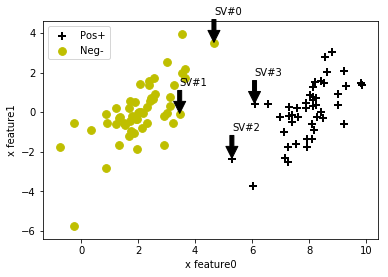

In [7]:
X=np.mat(X_train)
y=np.mat(y_train).transpose()
neg = np.where(y==-1)
pos = np.where(y==1)
neg=neg[0]
pos=pos[0]
#rint(neg.shape)
#rint(neg)
axes = plt.gca()
X_neg=np.zeros([neg.shape[0],2],np.float32)
X_pos=np.zeros([pos.shape[0],2],np.float32)
for i in range(neg.shape[0]):
    X_neg[i]=X[neg[i]]
for i in range(pos.shape[0]):
    X_pos[i]=X[pos[i]]
    
axes.scatter(X_pos[:,0], X_pos[:,1], marker='+', c='k', s=60, linewidth=2, label="Pos+")
axes.scatter(X_neg[:,0], X_neg[:,1], c='y', s=60, label="Neg-")
axes.set_xlabel("x feature0")
axes.set_ylabel("x feature1")
axes.legend(frameon= True, fancybox = True);

idx=0
for i in XS:
    plt.annotate(
    # Label and coordinate
    'SV#%d'%idx, xy=(X[i,0],X[i,1]), xytext=(X[i,0],X[i,1]+1.414),
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.02))
    idx+=1


### Platt SMO

1. 提供辅助函数选择使Ei-Ej变化最大的j.


$$f(X_k)=(\alpha*y)^T*(XX_k^T)+b$$
$$E_k=f(X_k)-y_k$$

In [18]:
class optStruc:
    # 类的初始化. 
    def __init__(self,dataMatIn,classLabels,C,toler):
        self.X=dataMatIn
        self.y=classLabels.transpose()
        self.C=C
        self.tor=toler
        self.m=dataMatIn.shape[0]
        self.alphas=np.mat(np.zeros((self.m,1),np.float32))
        self.b=0#np.mat(np.zeros((self.m,1),np.float32))
        self.eCache=np.mat(np.zeros((self.m,2),np.float32)) # 这里是2列的意思是,第0列是为了标记非边界的j的集合.第1列是对应的Ei-Ej
    
    # 计算第k个alpha和oS的差
def calcEk(oS,k): # 这个oS是self类型的.
    fXk=float(np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T))+oS.b
    Ek=fXk-float(oS.y[k])
    return Ek

# 对于外循环i来说,找到内循环的j
# 两种方法:
# 1. 第一次初始化的时候alphas都是0,都在边界上.
#    此时从(1,m)中随机一个非i的值作为j
# 2. 之后选择alphas中不再边界上的非i的alpha.
#    依次计算所有的alpha的E和Ei的差.
#    找最大的差的那个alpha,作为j
def selectJ(i,oS,Ei):
    maxDeltaE=0
    Ej=0
    oS.eCache[i]=[1,Ei]                # 把当前这个alphas[i]标记成非边界的. 并保存其对应的Ei.这个Ei是由上面的calcEk计算而来的.
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0]
    if len(validEcacheList)>1:
        # 找到最大的Ei－Ej
        for k in validEcacheList:
            if k==i: # 处理相等条件
                continue
            Ek=calcEk(oS,k)           #  oS.eCache[k,1] 此时还没有计算出来呢，不能直接取．
            deltaE=np.abs(Ei-Ek)      #  注意此处需要做abs
            if maxDeltaE<deltaE:
                maxDeltaE=deltaE
                j=k
                Ej=Ek
        
        return j,Ej
    else:
        j=selectJrand(i,oS.m)
        Ej=calcEk(oS,j)
    return j,Ej
def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,k]
        

In [19]:
# 计算内循环
# 考察不满足KKT条件的alphas.
# 更新eta
# 更新L和H
# 及时判断中途的退出点
# 如果不退出了,就计算alphas[i]和alphas[j]的更新
#     同时要更新Ei和Ej到缓存eCache中.
def innerL(i,oS):
    
    DEBUG_SVM=True
    if DEBUG_SVM == True:
        print(oS.X.shape)
        print(oS.y.shape)
        print((np.multiply(oS.alphas,oS.y).T).shape)
    # step1. 选择j
    Ei=calcEk(oS,i)
    j=selectJ(i,oS,Ei)
    Ej=calcEk(oS,j)
    
    # step2. 判断是否满足KKT条件
    if (Ei*oS.y[i]<(-oS.tor)and (alphas[i]<C)or (Ei*oS.y[i]>oS.tor) and (alphas[i]>0)):
        alpha_i_old=alphas[i].copy()
        alpha_j_old=alphas[j].copy()
        if oS.y[i]!=oS.y[j]:
            L=max(0, oS.alphas[j] - oS.alphas[i])
            H=min(C,oS.alphas[j]-oS.alphas[i]+oS.C)
        else:
            L=max(0, oS.alphas[j] + oS.alphas[i]-oS.C)
            H=min(C,oS.alphas[i]+oS.alphas[j])
        if L==H:
            print("L==H")
            return 0
        eta=2.0*oS.X[i,:]*oS.X[j,:].T-X[i,:]*oS.X[i,:].T-X[j,:]*oS.X[j,:].T
        if eta>=0:
            print("eta >=0")
            return 0
        oS.alphas[j]-=oS.y[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if (np.abs(oS.alphas[j]-alpha_j_old)<0.001):
            print("j not moving enough")
            return 0
        oS.alphas[i]+=oS.y[i]*oS.y[j]*(alpha_j_old-oS.alphas[j])
        updateEk(oS,i)
        b1 = oS.b - Ei- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
        if (0<alphas[i])and (alphas[i]<C):
            oS.b=b1
        elif (0<alphas[j])and (alphas[j]<C):
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        return 1
    else:
        return 0
    
            

In [20]:
def smoPlatt(X,y,C,toler,maxIter):
    oS=optStruc(X,y.transpose(),C,toler)
    iteritem=0
    entireSet=True
    alphasChanged=0
    
    DEBUG_SVM=True
    if DEBUG_SVM == True:
        print(X.shape)
        print(y.shape)
        
    while (iteritem<maxIter) and ( (alphasChanged>0)or (entireSet)):
        alphasChanged=0
        if entireSet: # 第一次进来,肯定遍历所有的item的.
            for i in range(oS.m):
                alphasChanged+=innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphaPairsChanged))
            iteritem+=1
        else: # 仅仅对非边界的alphas做调整.
            #选出既不等于0,也不等于C的alphas
            nonBoundries=np.nonzero((alphas.A>0)*(alphas.A<C))[0]
            for i in nonBoundries:
                alphasChanged+=innerL(i,oS)
                print("non-Boundries, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphaPairsChanged))
            iteritem+=1
        if entireSet:
            entireSet=False
        
        if alphasChanged==0: # 如果内循环没有满足的alpha,此时重新进入遍历. 与simple smo不同的是,simple smo会清零iteritem,导致多次遍历.我们这边仅仅把entirSet标志置位.
            entireSet=True
        print("iteration num :%d",iter)
        
    return oS.b,oS.alphas

X=np.mat(X_train)
y=np.mat(y_train).transpose()
b,alphas=smoPlatt(X,y,0.6,0.001,40)

(100, 2)
(100, 1)
(100, 2)
(100, 1)
(1, 100)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices